In [1]:
using LinearAlgebra, Random
using FillArrays, LogExpFunctions, Distributions, Optim, StatsPlots, Turing
using Random: GLOBAL_RNG

┌ Info: 
│   a = 2
│   b = 3
└ @ Main In[2]:9


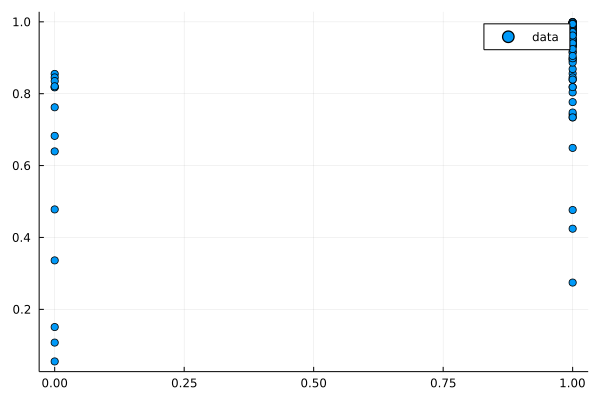

In [2]:
rng = MersenneTwister(43)

N = 100
z = rand(rng, Normal(0, 1), N) # latent variable
a, b = 2, 3 # param
p = logistic.(a .* z .+ b) # linear map followed by sigmoid
x = rand.(Ref(rng), Bernoulli.(p))

@info "" a b

p_data = scatter(x, p; label="data")

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


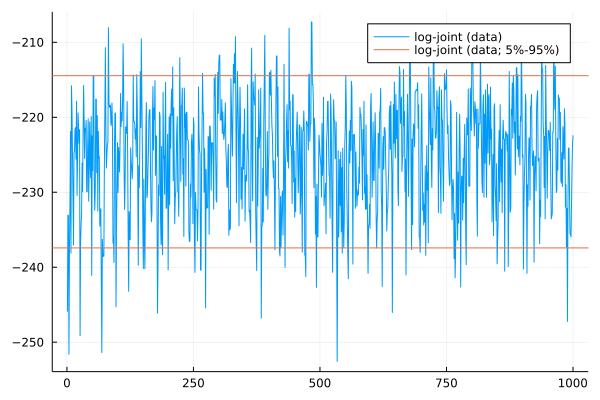

In [3]:
@model function lvm(x, param)
    latent ~ filldist(Normal(0, 2), length(x))
    a, b = param
    p = logistic.(a * latent .+ b)
    x ~ arraydist(Bernoulli.(p))
end

chain = sample(lvm(x, [a, b]), HMC(0.4, 8), 1_000)

logjoint_gt_lower = quantile(chain[:lp][div(end,2):end], 0.05)
logjoint_gt_upper = quantile(chain[:lp][div(end,2):end], 0.95)

plot(chain[:lp]; label="log-joint (data)") # check the trace of log-joint to see if the chain converges
hline!([logjoint_gt_lower, logjoint_gt_upper]; label="log-joint (data; 5%-95%)")

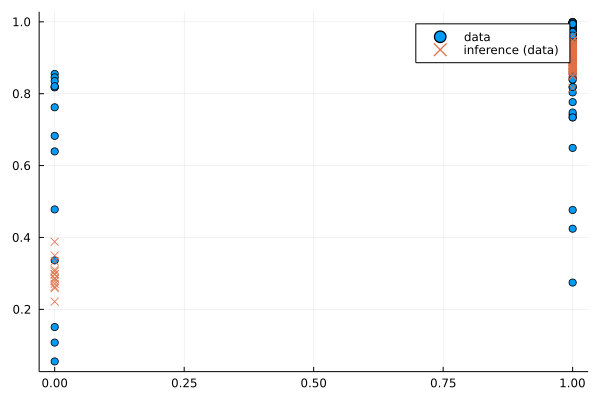

In [4]:
function get_latent(chain; keep_pct=.5, use_every=10)
    latent_all = chain.value.data[floor(Int,keep_pct*end):use_every:end,1:100]
    return transpose(latent_all) # [latent_dim, num_samples]
end

latent_all = get_latent(chain)
p_all = logistic.(a .* latent_all .+ b)
# Check if p with sampled latent variables are consistent with that of ground truth
scatter!(p_data, x, mean(p_all; dims=2); marker=:x, label="inference (data)")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


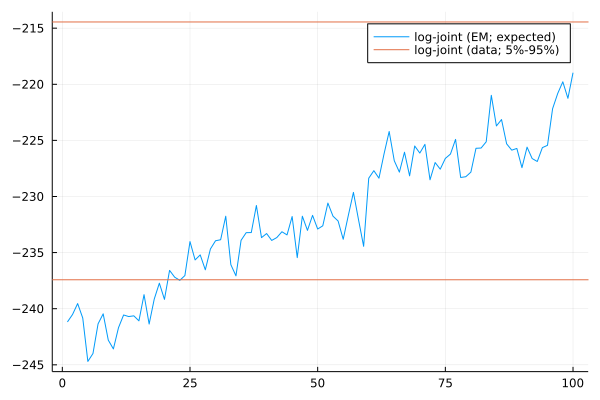

In [6]:
using ProgressMeter

init_param(rng=GLOBAL_RNG) = randn(rng, 2)

function make_obj(latent_all)
    obj = param -> -mean([logjoint(lvm(x, param), (; latent=latent)) for latent in eachcol(latent_all)])
    return obj
end

Random.seed!(4321) # EM can be super sensitive to initilization

param = init_param()
sampler = HMC(0.4, 8)
num_samples = 400

num_iterations = 100

trace = (chn=[], opt=[],)

@showprogress for i in 1:num_iterations
    # E-step
    chn = sample(lvm(x, param), sampler, num_samples; progress=false)
    latent_all = get_latent(chn)
    # M-step
    opt = optimize(make_obj(latent_all), param, NelderMead())
    param = opt.minimizer
    
    push!(trace.chn, chn)
    push!(trace.opt, opt)
end

plot(map(opt -> -opt.minimum, trace.opt), label="log-joint (EM; expected)")
hline!([logjoint_gt_lower, logjoint_gt_upper]; label="log-joint (data; 5%-95%)")

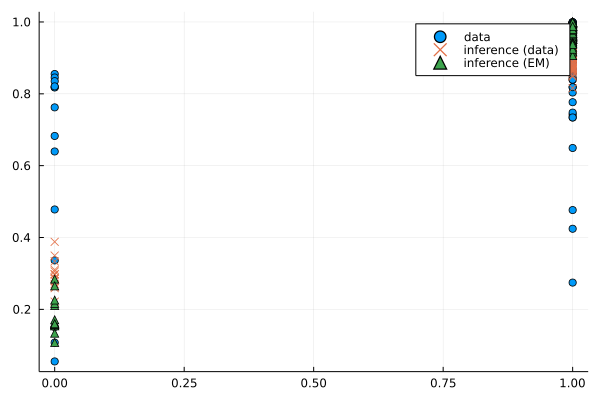

In [7]:
param = trace.opt[end].minimizer

latent_all = get_latent(trace.chn[end])
p_all = logistic.(param[1] .* latent_all .+ param[2])

# Happy if the inference based on true param (data) is close to that of EM's
scatter!(p_data, x, mean(p_all; dims=2); marker=:^, label="inference (EM)")